In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from scipy import stats

%matplotlib inline

sns.set_style("whitegrid")

/Users/conormd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


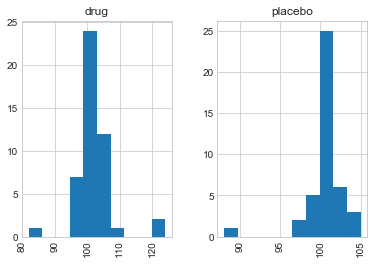

In [7]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');

In [8]:
iq_model = pm.Model()

# specify a model for difference in IQ for drug and placebo group
# for continuous response variables we can model the likelihood with a normal distribution

with iq_model:
    # mean and standard deviation for drug likelihood
    dr_mu = pm.Normal("mean_drug", y.value.mean(), y.value.std())
    dr_sd = pm.HalfCauchy("sd_drug", 2)
    
    pl_mu = pm.Normal("mean_pl", y.value.mean(), y.value.std())
    pl_sd = pm.HalfCauchy("sd_pl", 2)

    dr = pm.Normal("drug_group", dr_mu, dr_sd, observed=y1)
    pl = pm.Normal("placebo_group", pl_mu, pl_sd, observed=y2)
    
    mean_diff = pm.Deterministic("means_diff", dr_mu - pl_mu)
    sd_diff = pm.Deterministic("sds_diff", np.sqrt((dr_sd - pl_sd)**2))
    
    maginitude = pm.Deterministic("mag", dr_mu/pl_mu)
    
    out = pm.sample(5000, njobs=2)[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_pl_log__, mean_pl, sd_drug_log__, mean_drug]
100%|██████████| 5500/5500 [00:05<00:00, 1014.48it/s]


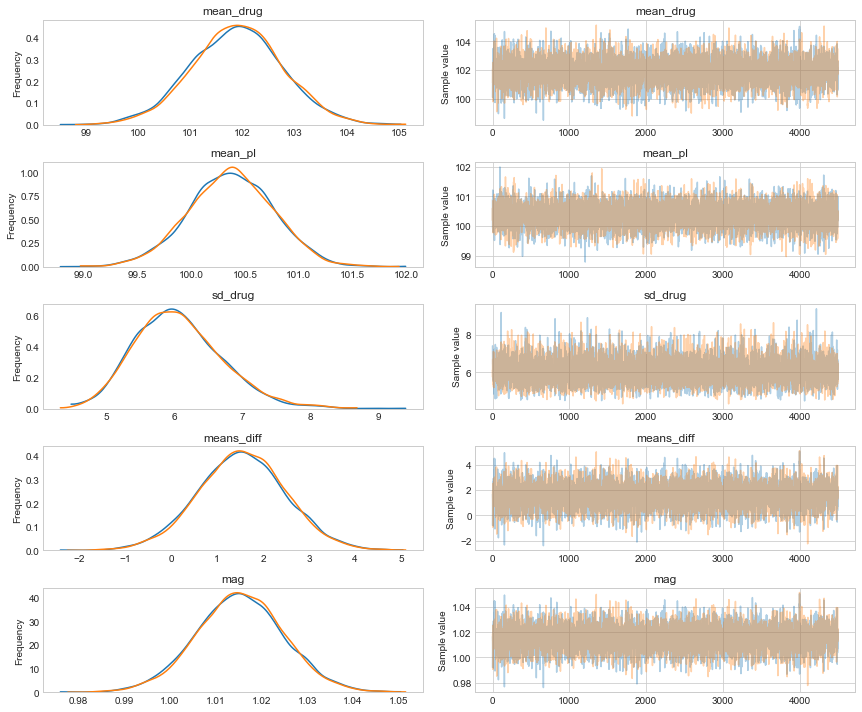

In [9]:
pm.traceplot(out, varnames=["mean_drug", "mean_pl", "sd_drug", "means_diff", "mag"]);

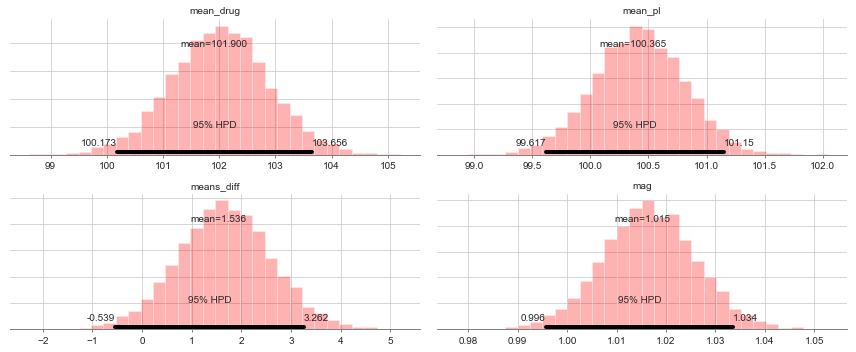

In [10]:
pm.plot_posterior(out, varnames=["mean_drug", "mean_pl", "means_diff", "mag"], color='r', alpha=.3);

In [11]:
pm.summary(out)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean_drug,101.900198,0.877639,0.009616,100.172964,103.655847,8522.0,1.000305
mean_pl,100.364642,0.392892,0.003609,99.616500,101.150115,9000.0,0.999892
sd_drug,6.058984,0.647381,0.006579,4.871776,7.367241,9000.0,0.999966
sd_pl,2.556653,0.285059,0.002754,2.043911,3.140109,9000.0,0.999917
means_diff,1.535556,0.956048,0.010398,-0.539138,3.261898,8621.0,1.000265
sds_diff,3.502330,0.707373,0.007368,2.112314,4.866249,9000.0,0.999993
mag,1.015315,0.009550,0.000104,0.995684,1.033619,8627.0,1.000264


In [12]:
(out["means_diff"] > 0).sum() / out["means_diff"].shape[0]

0.9456666666666667

### Classical t-test

In [74]:
t_stat = 1.559010/0.950721
df = y.shape[0] - 2
print(t_stat)

1.639818621866983


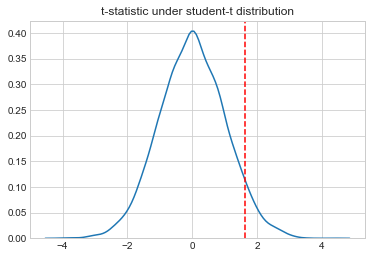

In [75]:
tdi = np.random.standard_t(df=df, size=10000)
sns.kdeplot(tdi)
plt.axvline(x=t_stat, c="r", linestyle="--")
plt.title("t-statistic under student-t distribution");

In [78]:
# calcuulcate p-value for t-statistic (mean of mean_diff/std of mean_diff)
pval = stats.t.pdf(1.56/0.977778, df=df)
print("p-value for t-statistic: {}".format(pval.round(3)))
print("Statistically significant at 0.05: {}".format(pval < 0.05))

p-value for t-statistic: 0.112
Statistically significant at 0.05: False


In [77]:
stats.t.pdf

<bound method rv_continuous.pdf of <scipy.stats._continuous_distns.t_gen object at 0x10a864588>>

In [188]:
dr_pl_diff_n = (out["mean_drug"] > out["mean_pl"]).sum() / 5000
print("Probability that taking the drug results in higher IQ: {}".format(dr_pl_diff_n))

Probability that taking the drug results in higher IQ: 0.9482


### ...as a final check

In [187]:
t, p = stats.ttest_ind(y1, y2, axis=0, equal_var=False)
print("t-statistic: {}\np value: {}".format(t.round(3), p.round(3)))

t-statistic: 1.622
p value: 0.11


In [10]:
exposures = 500
a = 23
b = 27

tbl = np.array([[a, exposures - a], 
              [b, exposures - b]])

In [11]:
tbl

array([[ 23, 477],
       [ 27, 473]])

In [15]:
stats.chi2_contingency(tbl)[:2]

(0.1894736842105263, 0.6633550269772723)